In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import itertools
from collections import defaultdict
from IPython.display import clear_output

# Classes

In [2]:
class Grid:
    def __init__(self, minute_part, hours = 24):
        self.hours = hours
        self.minute_part = minute_part
        self.Grid = pd.DataFrame(None, columns= [(y, x) for y in range(hours) for x in range(minute_part)], dtype = bool)
        
    def insert(self, idx, times: list):
        self.Grid.loc[idx] = [ x in set(times) for x in self.Grid.columns]
        
    def delete(self, idx):
        if idx in self.Grid.index:
            self.Grid.drop(index=idx, inplace= True)
        else:
            print("Not in index")
    
    def change(self, idx, times: list, value):
        self.Grid.loc[idx] = [ value if x in set(times) else y for x,y in zip(self.Grid.columns, self.Grid.loc[idx])]
    
    def isAvailable(self, idx, times: list):
        if idx not in self.Grid.index:
            print("Not an appropriate index")
            return False
        
        pos = self.Grid.index.get_loc(idx)
        return self.Grid.iloc[pos, times[0]*self.minute_part + times[1]]
    
    def getTotal(self, times):
        return self.Grid[times].sum()
    def getTotalbyidx(self, idx):
        return self.Grid.loc[idx].sum()
    
    def getAvailable(self, time):
        return self.Grid.loc[self.Grid[time] == True][time]
    
    def getEntropy(self):
        if self.Grid.shape[0] == 0 or self.Grid.shape[1] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        EntropybyRow = np.zeros(shape=(self.Grid.shape[0],1))
        EntropybyCol = np.zeros(shape=(1,self.Grid.shape[1]))

        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            EntropybyRow[count] = entropy([prob, 1-prob])

        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            EntropybyCol[0,count] = entropy([prob, 1-prob])
    
        EntTable = EntropybyCol+EntropybyRow
        EntTable[~self.Grid.to_numpy()] = np.inf
        #print("E Done")
        return EntTable
    
    def getMutualInformation(self):
        
        if self.Grid.shape[0] == 0 or self.Grid.shape[1] == 0:
            return np.zeros(shape=self.Grid.shape)
        
        ProbByRow = np.zeros(shape=(self.Grid.shape[0],1))
        ProbByCol = np.zeros(shape=(1,self.Grid.shape[1]))
        
        for count, person in enumerate(self.Grid.index):
            prob = self.getTotalbyidx(person)/self.Grid.shape[1]

            ProbByRow[count] = prob

        for count, time in enumerate(self.Grid):
            prob = self.getTotal(time)/self.Grid.shape[0]
        
            ProbByCol[0,count] = prob
            
        probTable = ProbByRow * ProbByCol
        
        for row in range(probTable.shape[0]):
            for col in range(probTable.shape[1]):
                probTable[row, col] = entropy([probTable[row,col], 1-probTable[row,col]])
        
        #print(probTable)
        #print("Done")
        return self.getEntropy() - probTable
        
    def getNextAvailable(self, time):
        ser = self.getAvailable(time)
        return ser.sort_index(key = lambda x: [self.getTotalbyidx(y) for y in x])
    def print(self):
        print(self.Grid)
    

In [3]:
class Person:
    newid = itertools.count()
    def __init__(self, id = None, availability= set()):
        if id is None:
            self.id = next(Person.newid)
        else:
            self.id = id
            
        self.availability = set()
        
    def reset():
        Person.newid = itertools.count()
        
            

In [4]:
def getBestSpot(people, grid):
    
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    #print(EntTable.shape)
    
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = defaultdict(int)
    ct = 1
    #print(best)
    while len(set(best.values())) != len(best):
        last = {}
        for count, k in enumerate(best):
            
            if best[k] not in last:
                last[best[k]] = k
                #print(last)
            else:
                #compare with last instance of the entropy table index
                #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                test_last = tableInd[last[best[k]], idxCt[last[best[k]]]+1 ]
                test_new = tableInd[count, idxCt[k]+1]
                
                if EntTable[ last[best[k]] , best[ last[best[k]] ] ] > EntTable[count, best[k]]:
                    #print("Index: ", last[best[k]] , " Entropy: ", EntTable[ last[best[k]], best[ last[best[k]] ] ])
                    #print("Second Index: ", k, " Entropy: ", EntTable[count, best[k]])
                    
                    if idxCt[last[best[k]]] > 0 and tableInd[last[best[k]], idxCt[last[best[k]]]-1] not in best.values():
                        #print(tableInd[last[best[k]], idxCt[last[best[k]]]-1] , best.values())
                        
                        idxCt[ last[best[k]] ] -= 1
                        #clear_output(wait=True)
                        
                        last[best[k]] = k
                        
                    elif not np.isinf(EntTable[ last[best[k]], test_last]):
                        idxCt[ last[best[k]] ] += 1
                        last[best[k]] = k
                    else:
                        #print("Testing Other... ")
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                    #print("prior min idxCt: ", idxCt[last[best[k]]])
                elif EntTable[ last[best[k]] , best[ last[best[k]] ] ] > EntTable[count, best[k]]:
                    if idxCt[k] > 0 and tableInd[count, idxCt[k] -1] not in best.values():
                        idxCt[k] -= 1
                    elif not np.isinf(EntTable[count, test_new]):
                        idxCt[k] += 1
                    else:
                        #print("Testing Other... ")
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                            last[best[k]] = k
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                    #print("current min idxCt: ", idxCt[k])
                else:
                    if idxCt[k] > 0 and idxCt[last[best[k]] ] > 0:
                        if tableInd[count, idxCt[k] -1] not in best.values() and tableInd[last[best[k]], idxCt[last[best[k]]]-1] not in best.values():
                            if EntTable[count, idxCt[k] - 1] < EntTable[last[best[k]], idxCt[last[best[k]] ] -1]:
                                idxCt[k] -= 1
                            else:
                                idxCt[last[best[k]]] -= 1
                                last[best[k]] = k
                        elif tableInd[count, idxCt[k] -1] not in best.values():
                            idxCt[k] -= 1
                        else:
                            idxCt[last[best[k]]] -= 1
                            last[best[k]] = k
                            
                    elif idxCt[k] > 0 and tableInd[count, idxCt[k] -1] not in best.values():
                        idxCt[k] -= 1
                    elif idxCt[last[best[k]] ] > 0 and tableInd[last[best[k]], idxCt[last[best[k]]]-1] not in best.values():
                        idxCt[last[best[k]]] -= 1
                        last[best[k]] = k
                        
                    elif EntTable[count, test_new] < EntTable[last[best[k]], test_last]:
                        if not np.isinf(EntTable[ last[best[k]], test_last]):
                            idxCt[ last[best[k]] ] += 1
                            last[best[k]] = k
                        else:
                        #print("Testing Other... ")
                            if not np.isinf(EntTable[count, test_new]):
                                idxCt[k] += 1
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    else:
                        if not np.isinf(EntTable[count, test_new]):
                            idxCt[k] += 1
                        else:
                            #print("Testing Other... ")
                            if not np.isinf(EntTable[ last[best[k]], test_last]):
                                idxCt[ last[best[k]] ] += 1
                                last[best[k]] = k
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    
                    
            #update to current instance
            best[k] = tableInd[count, idxCt[k]]
            ct += 1
            print("Alg1:, ", len(set(best.values())), "/", len(best))
            if ct % 2 == 0:
                clear_output(wait=True)
                
            if ct == EntTable.size * 100:
                return None, tableInd, idxCt, EntTable
        
    return best, tableInd, idxCt, EntTable



In [5]:
def getBestSpot2(people, grid):
    #EntTable = grid.getEntropy()
    EntTable = grid.getMutualInformation()
    
    #return a list of indices representing Entropy in ascending order
    tableInd = EntTable.argsort(axis=1)
 
    best = {person.id: table[0] for person, table in zip(people ,tableInd)}
    idxCt = defaultdict(int)
    
    #for each key set a counter to the beginning of the list
    ct = 1
    #condition to ensure each one is unique
    while len(set(best.values())) != len(best):
        conflict = {}
        #find conflicts
        for k in best:
            if best[k] not in conflict:
                conflict[best[k]] = []
            
            conflict[best[k]].append(k)
        #resolve conflicts
        
        for k in conflict:
            minCidx = 0
            #for each step compare to previous minimum value in Information Table (EntTable) and
            # if no longer the min value or if greater - incriment counter on respective keys
            for count, val in enumerate(conflict[k]):
                if val == conflict[k][minCidx]:
                    #print("Next")
                    continue

                test_last = tableInd[conflict[k][minCidx], idxCt[conflict[k][minCidx]]+1 ]
                test_new = tableInd[val, idxCt[val]+1]
                
                if EntTable[val, k] < EntTable[conflict[k][minCidx], k]:
                    #print("less")
                    if idxCt[conflict[k][minCidx]] > 0 and tableInd[conflict[k][minCidx], idxCt[conflict[k][minCidx] ]-1] not in conflict:
                        idxCt[conflict[k][minCidx]] -= 1 #drop from conflict and move to next
                        minCidx = count
                    elif not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                        idxCt[conflict[k][minCidx]] += 1
                        minCidx = count
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                
                elif EntTable[val, k] > EntTable[conflict[k][minCidx], k]:
                    #print("more")
                    if idxCt[conflict[k][count]] > 0 and tableInd[conflict[k][count], idxCt[conflict[k][count]] -1] not in conflict:
                        idxCt[conflict[k][count]] -= 1
                    elif not np.isinf(EntTable[val, test_new]):
                        idxCt[conflict[k][count]] += 1
                    else:
                        if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                            idxCt[conflict[k][minCidx]] += 1
                            minCidx = count
                        else:
                            print("Unresolvable")
                            return None, tableInd, idxCt, EntTable
                #when equal resolve by next least value
                else:
                    if idxCt[conflict[k][count]] > 0 and idxCt[conflict[k][minCidx]] > 0:
                        if tableInd[conflict[k][count], idxCt[conflict[k][count]] -1] not in conflict and tableInd[conflict[k][minCidx], idxCt[conflict[k][minCidx] ]-1] not in conflict:
                            
                            if EntTable[conflict[k][count], tableInd[conflict[k][count], idxCt[conflict[k][count]] -1] ] < EntTable[conflict[k][minCidx], tableInd[conflict[k][minCidx], idxCt[conflict[k][minCidx] ]-1] ]:
                                idxCt[conflict[k][count]] -= 1
                            else:
                                idxCt[conflict[k][minCidx]] -= 1
                                minCidx = count
                                
                        elif tableInd[conflict[k][count], idxCt[conflict[k][count]] -1] not in conflict:
                            idxCt[conflict[k][count]] -= 1
                        else:
                            idxCt[conflict[k][minCidx]] -= 1
                            minCidx = count
                            
                    elif idxCt[conflict[k][minCidx]] > 0 and tableInd[conflict[k][minCidx], idxCt[conflict[k][minCidx] ]-1] not in conflict:
                        idxCt[conflict[k][minCidx]] -= 1 #drop from conflict and move to next
                        minCidx = count
                        
                    elif idxCt[conflict[k][count]] > 0 and tableInd[conflict[k][count], idxCt[conflict[k][count]] -1] not in conflict:
                        idxCt[conflict[k][count]] -= 1
                        
                    #break ties on lookahead
                    elif EntTable[val, test_new] < EntTable[conflict[k][minCidx], test_last]:
                        if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                            idxCt[conflict[k][minCidx]] += 1
                            minCidx = count
                        else:
                            if not np.isinf(EntTable[val, test_new]):
                                idxCt[conflict[k][count]] += 1
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable
                    else:
                        if not np.isinf(EntTable[val, test_new]):
                            idxCt[conflict[k][count]] += 1
                        else:
                            if not np.isinf(EntTable[conflict[k][minCidx], test_last]):
                                idxCt[conflict[k][minCidx]] += 1
                                minCidx = count
                            else:
                                print("Unresolvable")
                                return None, tableInd, idxCt, EntTable

            print("Alg2:, ", len(set(best.values())), "/", len(best))
            ct+= 1
            #update table
            for k in best:
                best[k] = tableInd[k, idxCt[k]]
            if ct % 2 == 0:
                clear_output(wait=True)
            if ct == EntTable.size * 100:
                return None, tableInd, idxCt, EntTable
        
    return best, tableInd, idxCt, EntTable

# Test Classes

In [6]:
HOUR_PARTITIONS = 48
HOURS = 24
Num_People = 26
def fillGrid(perc):
    return math.floor(perc* (HOUR_PARTITIONS*HOURS))
people = [Person() for x in range(Num_People)]

In [7]:
test = Grid(4, hours = 4)
#test.print()
test.insert(20, [(0,0),(0,3),(2,2)])

test.insert(0, [(0,3)])
test.insert(3, [(0,0)])
test.change(3, [(1,0)], True)

print("Test is Available: ", test.isAvailable(3, (1,1)), "\n" )
display(test.getAvailable((0,0)) )
print("\nTest Total by Row: ", test.getTotalbyidx(20))
print("Test Total by Column: ", test.getTotal((0,0)), "\n" )

display(test.getNextAvailable((0,0)) )
display(test.Grid)
print(test.Grid.shape)

Test is Available:  False 



20    True
3     True
Name: (0, 0), dtype: bool


Test Total by Row:  3
Test Total by Column:  2 



3     True
20    True
Name: (0, 0), dtype: bool

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
20,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


(3, 16)


In [8]:
test.delete(4)
test.getTotal((2,2))

Not in index


1

In [9]:
test.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (1, 0)  (1, 1)  (1, 2)  (1, 3)  (2, 0)  \
20    True   False   False    True   False   False   False   False   False   
0    False   False   False    True   False   False   False   False   False   
3     True   False   False   False    True   False   False   False   False   

    (2, 1)  (2, 2)  (2, 3)  (3, 0)  (3, 1)  (3, 2)  (3, 3)  
20   False    True   False   False   False   False   False  
0    False   False   False   False   False   False   False  
3    False   False   False   False   False   False   False  


In [10]:
test.isAvailable(4, (2,2))

Not an appropriate index


False

In [11]:
test.isAvailable(3, (1,0))

True

In [12]:
schedule = Grid(HOUR_PARTITIONS)

def createTupList(Hours, Minutes, size):
    #s = set()
    #while len(s) != size:
    #    s.add(tuple(np.random.randint(maxval, size = 2, dtype = np.uint64)))
    #print("\n", list(s))
    #print("Length of list: ", len(s))
    #return list(s)
    return [(np.random.randint(Hours, dtype=np.uint64), np.random.randint(Minutes, dtype=np.uint64)) for x in range(size)]

for person in people:
    r_size = np.random.randint(schedule.Grid.shape[1], dtype = np.uint64)
    #print(person.id)
    schedule.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
schedule.print()

    (0, 0)  (0, 1)  (0, 2)  (0, 3)  (0, 4)  (0, 5)  (0, 6)  (0, 7)  (0, 8)  \
0    False   False   False   False    True   False    True   False   False   
1    False   False   False   False   False   False   False    True   False   
2    False   False   False   False   False   False   False   False   False   
3    False    True    True   False   False   False    True    True   False   
4     True   False   False   False   False   False   False    True    True   
5    False    True    True   False    True    True   False    True    True   
6    False   False   False   False   False    True   False   False   False   
7    False    True   False   False    True   False   False   False    True   
8    False   False   False    True   False   False   False   False   False   
9    False   False   False    True   False   False   False   False   False   
10   False    True   False   False   False    True   False   False   False   
11   False    True   False    True    True   False    True    Tr

# Calculate the loss 
- Entropy of the person plus entropy of the space, H(P(x)/m*n) + H(M(x)/X)
    - minimize such that the total entropy of remaining spaces is the most possible
- where E(P(x)/m*n) is the entropy for person,P, and P(x) is total available
- where E(M(x)/X) is the entropy of available People, M(x), against total People, X
# Operations:
How to keep track of positions
How to deal with failure end state (is it reversible?)
How to represent success state (used dictionary)
Best way to find next position (sorted numpy array along index)

# Failure States:
When X > m*n
When dictionary reaches inf.
# Success state:
When all values in Dictonary are unique

In [13]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available in " + str(schedule.getTotalbyidx(person.id)) + " Spots\t\t"
    if count % 2 == 0:
        print(out)
        out = ""

if out != "":
    print(out)

0 Person available in 449 Spots		1 Person available in 23 Spots		
2 Person available in 106 Spots		3 Person available in 698 Spots		
4 Person available in 392 Spots		5 Person available in 598 Spots		
6 Person available in 217 Spots		7 Person available in 142 Spots		
8 Person available in 338 Spots		9 Person available in 131 Spots		
10 Person available in 179 Spots		11 Person available in 445 Spots		
12 Person available in 506 Spots		13 Person available in 625 Spots		
14 Person available in 510 Spots		15 Person available in 598 Spots		
16 Person available in 99 Spots		17 Person available in 172 Spots		
18 Person available in 481 Spots		19 Person available in 717 Spots		
20 Person available in 128 Spots		21 Person available in 539 Spots		
22 Person available in 638 Spots		23 Person available in 5 Spots		
24 Person available in 496 Spots		25 Person available in 696 Spots		


In [14]:
out = ""
for count, person in enumerate(people, 1):
    out += str(person.id) + " Person available {:.4%} of times\t".format(schedule.getTotalbyidx(person.id)/schedule.Grid.shape[1])
    if count % 2 == 0:
        print(out)
        out = ""
if out != "":
    print(out)

0 Person available 38.9757% of times	1 Person available 1.9965% of times	
2 Person available 9.2014% of times	3 Person available 60.5903% of times	
4 Person available 34.0278% of times	5 Person available 51.9097% of times	
6 Person available 18.8368% of times	7 Person available 12.3264% of times	
8 Person available 29.3403% of times	9 Person available 11.3715% of times	
10 Person available 15.5382% of times	11 Person available 38.6285% of times	
12 Person available 43.9236% of times	13 Person available 54.2535% of times	
14 Person available 44.2708% of times	15 Person available 51.9097% of times	
16 Person available 8.5938% of times	17 Person available 14.9306% of times	
18 Person available 41.7535% of times	19 Person available 62.2396% of times	
20 Person available 11.1111% of times	21 Person available 46.7882% of times	
22 Person available 55.3819% of times	23 Person available 0.4340% of times	
24 Person available 43.0556% of times	25 Person available 60.4167% of times	


In [15]:
disp = pd.DataFrame(schedule.getEntropy(), columns= schedule.Grid.columns)

In [16]:
display(disp)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,inf,inf,inf,inf,1.313672,inf,1.334918,inf,inf,inf,...,inf,1.334918,1.334918,inf,1.208843,1.334918,inf,inf,inf,1.285881
1,inf,inf,inf,inf,inf,inf,inf,0.764182,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,0.973451,inf,inf,0.973451,inf,inf,inf,inf
3,inf,1.336824,1.287787,inf,inf,inf,1.336824,1.336824,inf,1.351811,...,1.210750,inf,1.336824,1.360731,inf,inf,1.210750,inf,1.287787,inf
4,1.258461,inf,inf,inf,inf,inf,inf,1.307498,1.223712,1.322485,...,inf,inf,inf,1.331405,inf,inf,inf,inf,inf,inf
5,inf,1.358696,1.309659,inf,1.337451,1.121741,inf,1.358696,1.274910,inf,...,1.232622,inf,1.358696,1.382603,inf,inf,inf,1.309659,inf,inf
6,inf,inf,inf,inf,inf,0.913171,inf,inf,inf,inf,...,inf,inf,1.150126,1.174034,inf,inf,inf,1.101090,inf,inf
7,inf,1.039656,inf,inf,1.018411,inf,inf,inf,0.955870,inf,...,inf,inf,1.039656,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,1.250204,inf,inf,inf,inf,inf,1.286436,...,inf,1.271449,inf,inf,inf,inf,inf,inf,inf,inf
9,inf,inf,inf,0.999246,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,0.894417,inf,inf,inf,inf,0.971455


In [17]:
pd.DataFrame(schedule.getMutualInformation(), columns= schedule.Grid.columns)

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(23, 38)","(23, 39)","(23, 40)","(23, 41)","(23, 42)","(23, 43)","(23, 44)","(23, 45)","(23, 46)","(23, 47)"
0,inf,inf,inf,inf,0.918047,inf,0.912371,inf,inf,inf,...,inf,0.912371,0.912371,inf,0.906435,0.912371,inf,inf,inf,0.919105
1,inf,inf,inf,inf,inf,inf,inf,0.719142,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,0.820445,inf,inf,0.820445,inf,inf,inf,inf
3,inf,0.793901,0.806780,inf,inf,inf,0.793901,0.793901,inf,0.782614,...,0.806106,inf,0.793901,0.768111,inf,inf,0.806106,inf,0.806780,inf
4,0.923171,inf,inf,inf,inf,inf,inf,0.919449,0.917457,0.910391,...,inf,inf,inf,0.896658,inf,inf,inf,inf,inf,inf
5,inf,0.858775,0.870450,inf,0.866531,0.843311,inf,0.858775,0.870388,inf,...,0.866112,inf,0.858775,0.832004,inf,inf,inf,0.870450,inf,inf
6,inf,inf,inf,inf,inf,0.781994,inf,inf,inf,inf,...,inf,inf,0.890198,0.878635,inf,inf,inf,0.879774,inf,inf
7,inf,0.848842,inf,inf,0.842078,inf,inf,inf,0.810221,inf,...,inf,inf,0.848842,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,0.921701,inf,inf,inf,inf,inf,0.911359,...,inf,0.919022,inf,inf,inf,inf,inf,inf,inf,inf
9,inf,inf,inf,0.833332,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,0.772992,inf,inf,inf,inf,0.819776


In [18]:
points = [] # [ [[],[]], ...]
for idx, row in disp.iterrows():
    data = []
    col = []
    for count, (pt, column) in enumerate(zip(row,disp.columns)):
        if schedule.isAvailable(idx, column):
            col.append(count)
            data.append(pt)
    points.append([col, data])

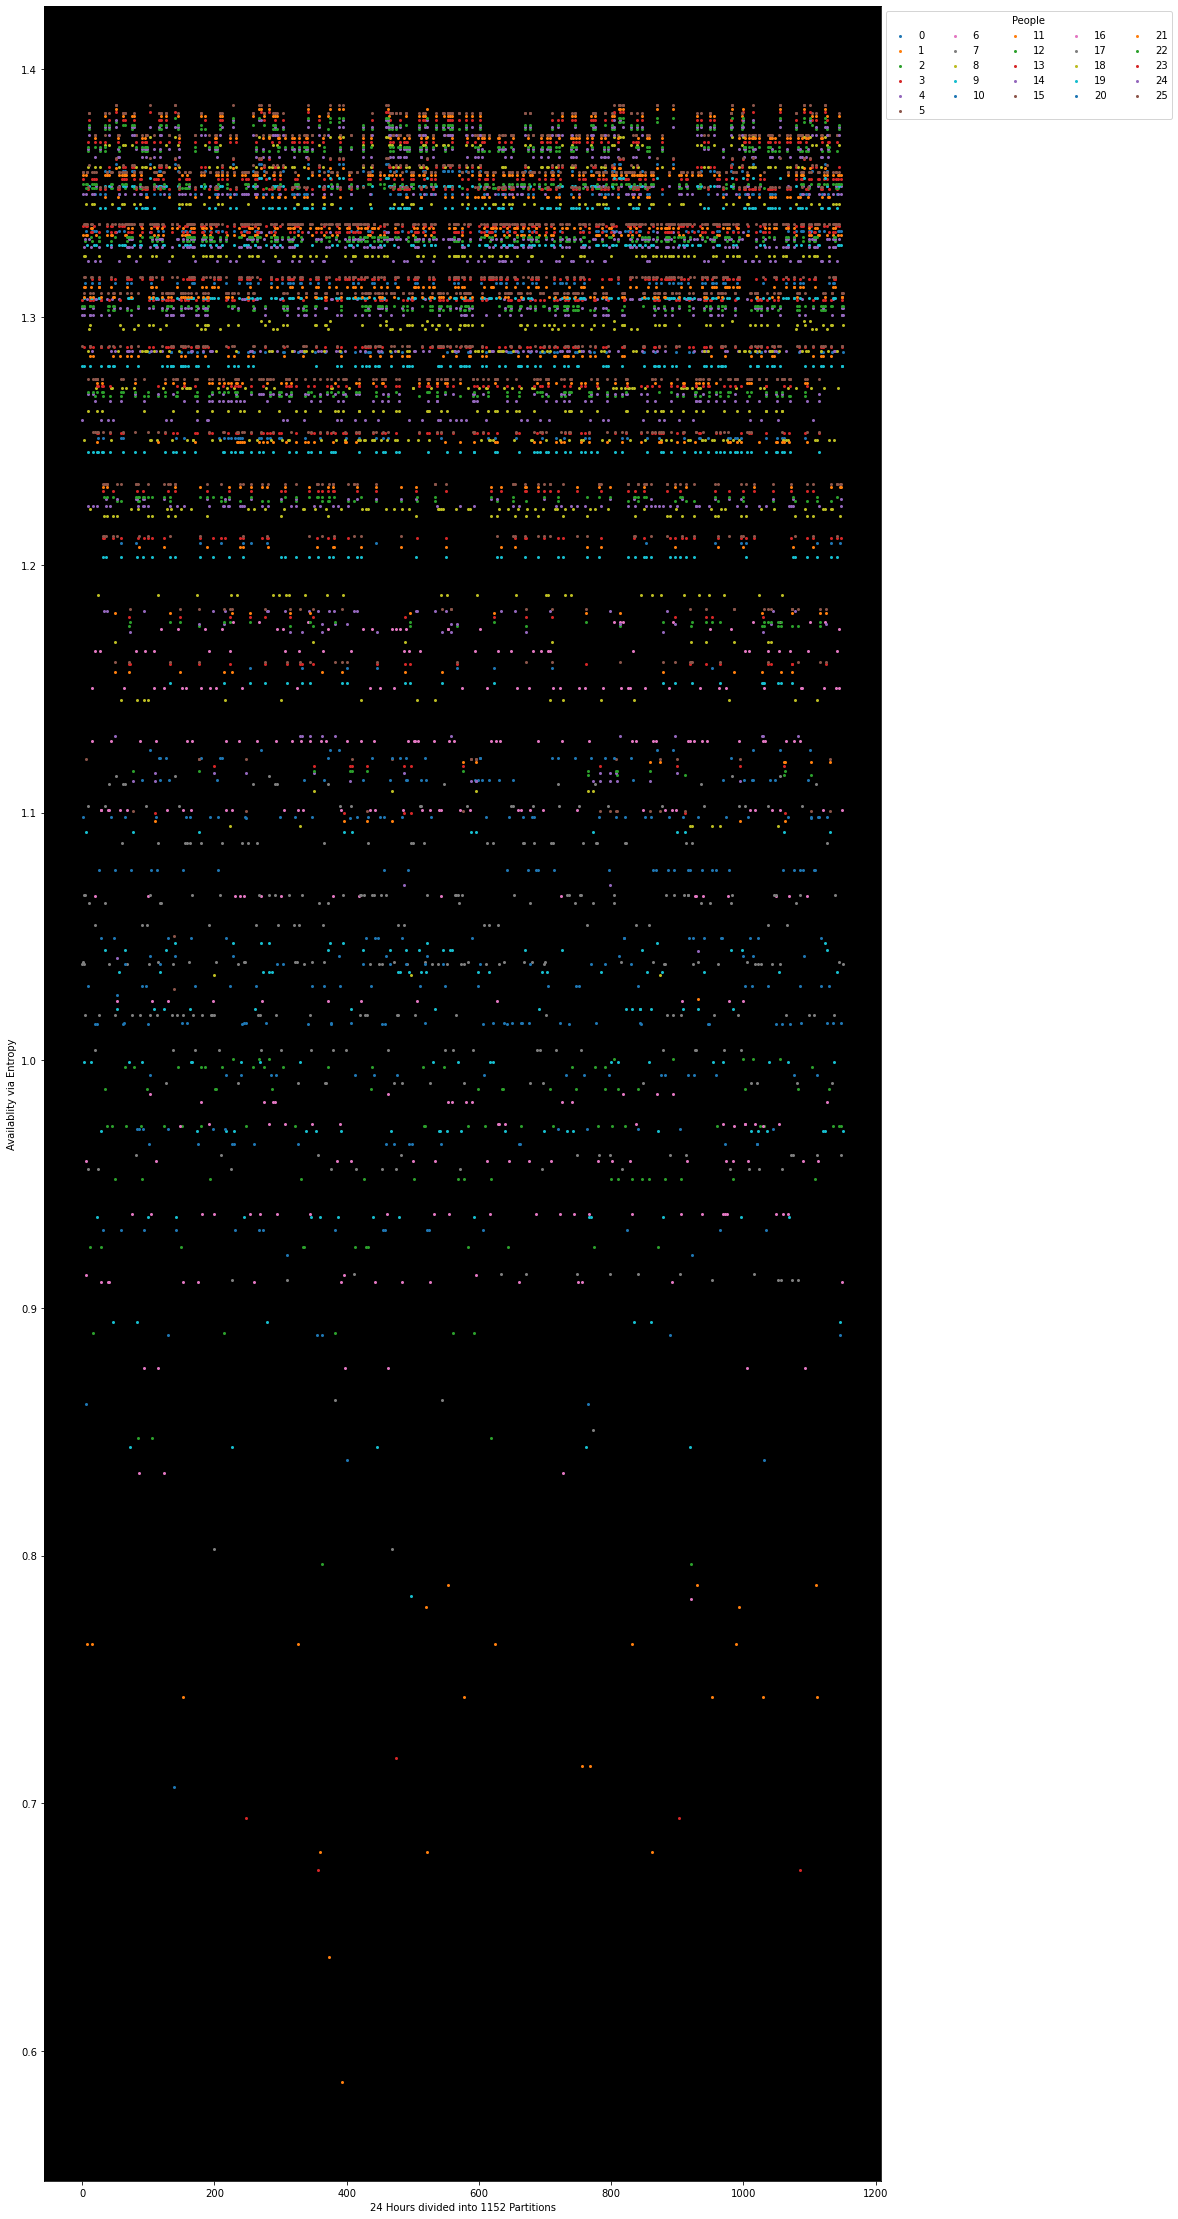

In [19]:
fig , ax = plt.subplots()

for pts, idx in zip(points, disp.index):
    ax.scatter(pts[0], pts[1], s = 4, label = idx)
    
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)

ax.set_facecolor('black')
ax.set_xlabel("{Hours:} Hours divided into {Min_part} Partitions".format(Hours=HOURS, Min_part = HOURS*HOUR_PARTITIONS))
ax.set_ylabel("Availablity via Entropy")
fig.set_figwidth(15)
fig.set_figheight(40)

#plot = plt.scatter(np.arange(len(disp.columns))+ np.zeros(shape=(len(disp.index), 1), dtype = int), disp.to_numpy())
plt.show()

In [20]:
#best, idxes, idxCts, Entropy = getBestSpot(people, schedule)

best2, idxes2, idxCts2, Entropy2 = getBestSpot2(people, schedule)

Alg2:,  26 / 26
Alg2:,  26 / 26


In [21]:
output = ""
summ = 0
for count, spot in enumerate(best):
    output += str(spot) + ": " + str(best[spot]) + ", Entropy: {:4}".format(Entropy[count,best[spot]]) + "\t\t"
    summ +=  Entropy[count,best[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total capacity:", summ)

NameError: name 'best' is not defined

In [21]:
output = ""
summ = 0
for count, spot in enumerate(best2):
    output += str(spot) + ": " + str(best2[spot]) + ", Entropy: {:4}".format(Entropy2[count,best2[spot]]) + "\t\t"
    summ +=  Entropy2[count,best2[spot]]
    if (count+1) % 2 == 0:
        print(output)
        output = ""
        
if output != "":
    print(output)
print("Total Capacity: ", summ)

0: 250, Entropy: 0.7749929080381183		1: 677, Entropy: 0.8480868514749408		
2: 744, Entropy: 0.7255308600928577		3: 602, Entropy: 0.853082936767514		
4: 374, Entropy: 0.8519440465965801		5: 698, Entropy: 0.6672926727894085		
6: 267, Entropy: 0.662948214844419		7: 985, Entropy: 0.8371342455960304		
8: 204, Entropy: 0.6580655684397869		9: 696, Entropy: 0.8405936007546485		
10: 922, Entropy: 0.8588579546296647		11: 1125, Entropy: 0.7230063279671275		
12: 881, Entropy: 0.8454989561093555		13: 515, Entropy: 0.6523636581968282		
14: 962, Entropy: 0.6856496049478222		15: 273, Entropy: 0.8337708402421733		
16: 766, Entropy: 0.7294066762576032		17: 577, Entropy: 0.8136063717403585		
18: 706, Entropy: 0.7627681456134684		19: 410, Entropy: 0.6614654039583707		
20: 463, Entropy: 0.8192001820767159		21: 92, Entropy: 0.7999033500329533		
22: 693, Entropy: 0.8408564168985194		23: 971, Entropy: 0.8254546180977437		
24: 509, Entropy: 0.6516416979970954		25: 466, Entropy: 0.8515999032964598		
Total Capac

In [23]:
print("farthest incriment, ", max(idxCts.values()))
#print(idxes[:, :max(idxCts.values())])
series = idxes[:, :max(idxCts.values())]
dataSet = []
for count, row in enumerate(series):
    vals = []
    for val in row:
        vals.append(Entropy[count, val])
        
    dataSet.append(vals)

NameError: name 'idxCts' is not defined

NameError: name 'dataSet' is not defined

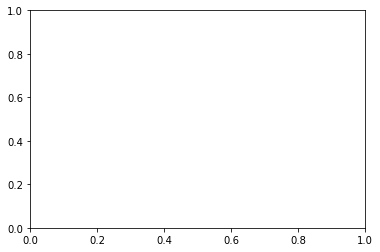

In [24]:
fig, ax = plt.subplots()

for count, (data, idx) in enumerate(zip(dataSet, series)):
    ax.scatter(idx, data, label = count)
EntVals = []
for k,v in best.items():
    EntVals.append(Entropy[k,v])
ax.legend(title = "People", loc = "upper left", bbox_to_anchor = (1, 1), ncol = math.floor(math.sqrt(disp.shape[0])), fancybox = True)
plt.show()

In [25]:
plt.scatter(best.values(), EntVals, c='black')
plt.show()

NameError: name 'best' is not defined

# Test

In [22]:
percents = [x/10 for x in range(0, 11, 2)]
TestSizes = []
ScheduleSet = [Grid(HOUR_PARTITIONS) for x in percents]
print(len(percents))
for perc in percents:
    Person.reset()
    TestSizes.append([Person() for x in range(fillGrid(perc))])

print("Set Loaded")
ct = 1
for timeSet, people in zip(ScheduleSet, TestSizes):
    
    for person in people:
        r_size = np.random.randint(timeSet.Grid.shape[1], dtype = np.uint64)
        #print(person.id)
        timeSet.insert(person.id, createTupList(HOURS, HOUR_PARTITIONS, r_size))
    
    print("Filled Set: ", ct)
    ct += 1   

6
Set Loaded
Filled Set:  1
Filled Set:  2
Filled Set:  3
Filled Set:  4
Filled Set:  5
Filled Set:  6


In [23]:
for timeSet in ScheduleSet:
    print(timeSet.Grid.shape)

(0, 1152)
(230, 1152)
(460, 1152)
(691, 1152)
(921, 1152)
(1152, 1152)


In [ ]:
for timeSet, People in zip(ScheduleSet, TestSizes):
    #b1, i, d, c = getBestSpot(People, timeSet)
    #print(b1)
    b2, i ,d, c = getBestSpot2(People, timeSet)
    print(b2)


Alg2:,  224 / 230
Alg2:,  224 / 230


In [29]:
import timeit
g = []
g2 = []
ct = 1
for timeSet, People in zip(ScheduleSet, TestSizes):
    t = timeit.Timer(lambda: getBestSpot(People, timeSet))
    t2 = timeit.Timer(lambda: getBestSpot2(People, timeSet))
    
    g.append(t.repeat(number = 10))
    
    print("Next")
    
    g2.append(t2.repeat(number = 10))
    
    print("Done at, ", ct)
    ct += 1

Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152
Alg2:,  1151 / 1152


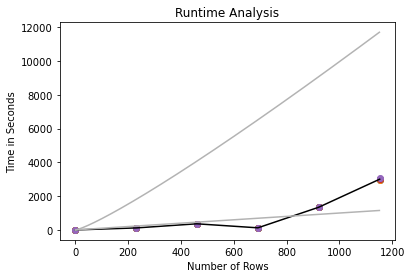

In [38]:
fig, ax = plt.subplots()
x = np.asarray([fillGrid(x) for x in percents])
y = np.asarray(g)

ax.plot(x[:, np.newaxis],y, 'o')
ax.plot(x, y.mean(axis=1), 'k')

ax.plot(np.arange(HOURS*HOUR_PARTITIONS), np.arange(HOURS*HOUR_PARTITIONS), '0.7')
ax.plot(np.arange(1, HOURS*HOUR_PARTITIONS), [x*math.log(x,2) for x in range(1, HOURS*HOUR_PARTITIONS)], '0.7')

ax.set_ylabel("Time in Seconds")
ax.set_xlabel("Number of Rows")
ax.set_title("Runtime Analysis")
plt.show()

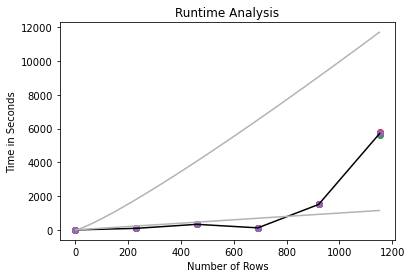

In [41]:
fig, ax = plt.subplots()
x = np.asarray([fillGrid(x) for x in percents])
y = np.asarray(g2)

ax.plot(x[:, np.newaxis],y, 'o')
ax.plot(x, y.mean(axis=1), 'k')

ax.plot(np.arange(HOURS*HOUR_PARTITIONS), np.arange(HOURS*HOUR_PARTITIONS), '0.7')
ax.plot(np.arange(1, HOURS*HOUR_PARTITIONS), [x*math.log(x,2) for x in range(1, HOURS*HOUR_PARTITIONS)], '0.7')

ax.set_ylabel("Time in Seconds")
ax.set_xlabel("Number of Rows")
ax.set_title("Runtime Analysis")
plt.show()